In [2]:
from glob import glob
import os
import pathlib
import pprint as pp

from keras.api._v2.keras.layers import Conv3DTranspose

pp.PrettyPrinter(indent=4)
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, Sequential
from tensorflow.keras.models import Model

2022-12-08 14:48:50.030400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 14:48:50.284807: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
print(tf.config.set_visible_devices.__doc__)

Set the list of visible devices.

  Specifies which `PhysicalDevice` objects are visible to the runtime.
  TensorFlow will only allocate memory and place operations on visible
  physical devices, as otherwise no `LogicalDevice` will be created on them.
  By default all discovered devices are marked as visible.

  The following example demonstrates disabling the first GPU on the machine.

  >>> physical_devices = tf.config.list_physical_devices('GPU')
  >>> try:
  ...   # Disable first GPU
  ...   tf.config.set_visible_devices(physical_devices[1:], 'GPU')
  ...   logical_devices = tf.config.list_logical_devices('GPU')
  ...   # Logical device was not created for first GPU
  ...   assert len(logical_devices) == len(physical_devices) - 1
  ... except:
  ...   # Invalid device or cannot modify virtual devices once initialized.
  ...   pass

  Args:
    devices: List of `PhysicalDevice`s to make visible
    device_type: (optional) Only configure devices matching this device type.
      For 

In [4]:
train_data = glob("./data/screw/train/good/*")
test_data = glob("./data/screw/test/**/*")

### Training Data
Just quickly taking a look at the training image. Just a random sample of images from the train set
and then a histogram of pixel values overlayed. Just for fun mostly but I noticed some of the pictures
have slightly darker or lighter exposure, so I wanted to get a sense of whether or not that would be
visible in a histogram. It could potentially be an issue later, but I'll just keep it in min for now.

#### A Mistake (Now fixed)
Also, the way I constructed the histogram is probably introducing some kind of normalization or value
mapping in a way that defeats my purpose for doing it in the first place, i.e. visually inspecting
variations in exposures through the histogram.

This is the case, because I used numpy.histogram and did not define the range parameter. This by
itself might have only meant a slight squishing of the hisogram (missing the true upper and lower
bound for each image), which is not great but then in order to get matplotlib to overlay the image
and the barplot I rescaled everything to fit in between the 0 to 1024 bounds of imagesize. 

```python
  # The offending code
  counts, values = np.histogram(img_data, bins=30)        # will add the "range" param
  counts = (counts/counts.max() * 1024) / 4
  values = values[1:] * 1024

````

Anyway, the way to fix it is to give the numpy function the correct range and then the `values`
part will be right. I don't care as much about the counts because it wouldn't matter in seeing
differences in photo exposure.

###### Side note:
I kind of wish I had a histogram that scaled the counts to be a more pleasing shape, but then
maybe displayed that info with color. Like the color is mapped to the level of scaling on a bin.
Maybe scalling is displayed as horizontal lines in the bin that are squished together or spread
out depending on the original size.

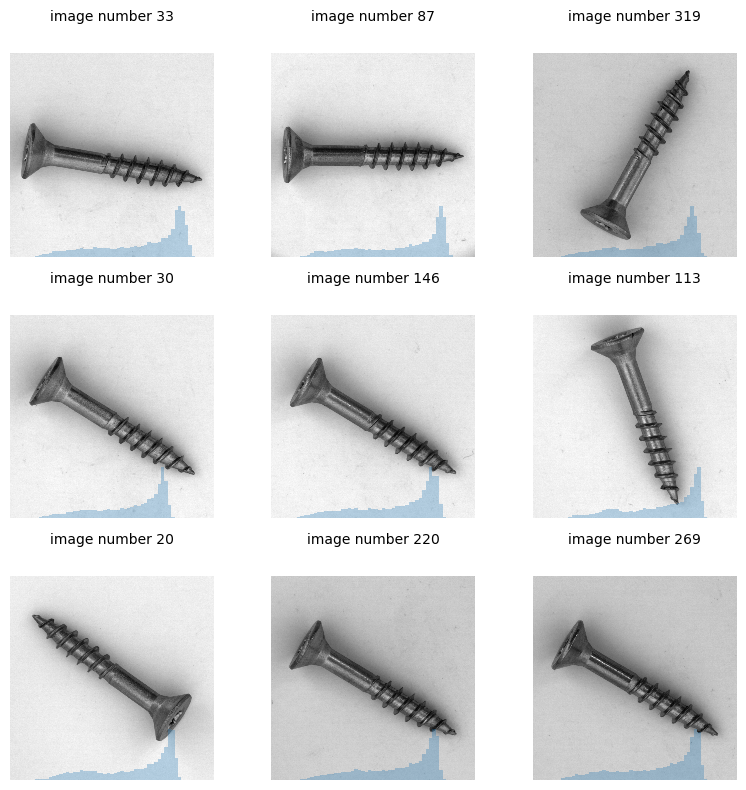

In [5]:
float_formatter = "{:8}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
fig, ax_list = plt.subplots(3, 3, figsize=(8,8))
# extent = (0, 1024, 0, 1024)
do_this = False
for ax in ax_list.flatten():
    img_num = np.random.randint(0, len(train_data))
    img = plt.imread(train_data[img_num])
    img_data = img.reshape(1024 * 1024)
    img_data = img_data * 1024
    counts, values = np.histogram(img_data, bins=60, range=(0, 1024))
    counts = counts**.5 / 2
    counts = (counts/counts.max() * 1024) / 4
    values = values[1:]
    bar_width = np.diff(values)
    ax.bar(values, counts, width=bar_width[0], alpha=.3)
    ax.matshow(img, cmap='gray', alpha=1, origin='lower')
    ax.set_title(f"image number {img_num}", fontsize=10)
    ax.set_xlim([0, 1024])
    ax.set_ylim([0, 1024])
    ax.axis('off')
fig.tight_layout()
plt.show()

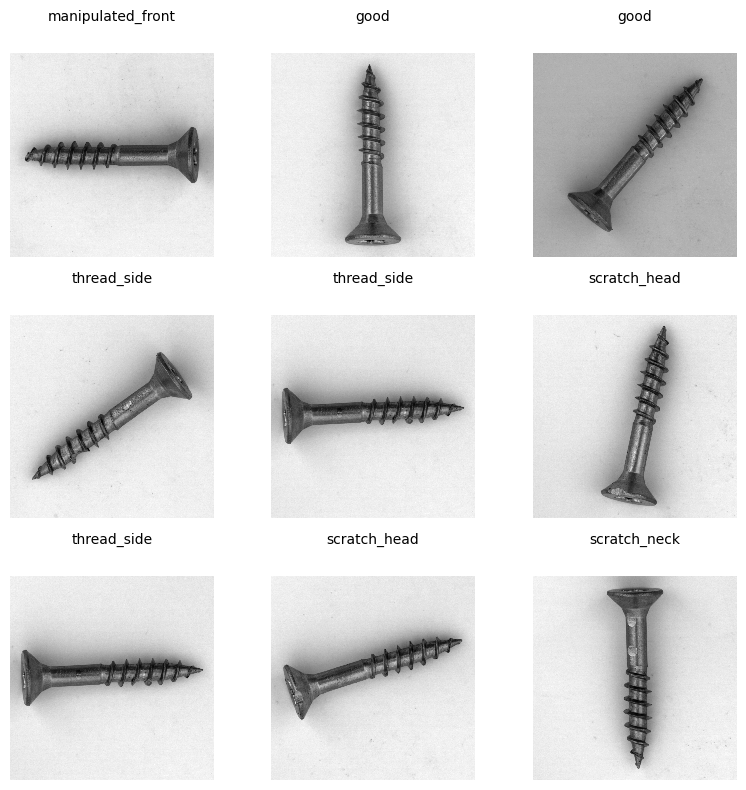

In [15]:
fig_test_samp, ax_test_sample = plt.subplots(3, 3, figsize=(8,8))
for ax in ax_test_sample.flatten():
    test_ind = np.random.randint(0, len(test_data))
    test_img = plt.imread(test_data[test_ind])
    ax.matshow(test_img, cmap='gray', origin='lower')
    ax.axis('off')
    ax.set_title(f"{test_data[test_ind].split('/')[-2]}", fontsize=10)
fig_test_samp.tight_layout()
plt.savefig("./images/eda_anom_grid.png")
plt.show()

In [7]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim * 4, activation='relu'),
            layers.Dense(latent_dim, activation='relu'),
            ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(latent_dim * 4, activation='relu'),
            layers.Dense(40000, activation='sigmoid'),
            layers.Reshape((200, 200))
            ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
print(f"train samples: {len(train_data)} | test samples: {len(test_data)}")

train samples: 320 | test samples: 160


In [9]:
train_dir = "./data/screw/train/"
train_dir = pathlib.Path(train_dir)
test_dir = "./data/screw/test/"
test_dir = pathlib.Path(test_dir)

In [10]:
batch_size, img_height, img_width = (320, 200, 200)
x_train = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                      seed=142,
                                                      image_size=(img_height, img_width),
                                                      color_mode='grayscale',
                                                      batch_size=None,
                                                      shuffle=False,
                                                      )

Found 320 files belonging to 1 classes.


2022-12-08 14:48:55.976817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-08 14:48:55.995801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-08 14:48:55.995881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-08 14:48:55.999777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-08 14:48:55.999818: I tensorflow/com

In [11]:
# test_batch = 160
x_test = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                     seed=142,
                                                     image_size=(img_height, img_width),
                                                     batch_size=None,
                                                     shuffle=False,
                                                     color_mode='grayscale',
                                                    )

Found 160 files belonging to 6 classes.


In [12]:
train_classes = x_train.class_names
train_classes

['good']

In [14]:
# TODO: Generalize this into a helper function
plt.figure(figsize=(8,8))
for images, labels in x_train:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images.numpy().astype("float16"), cmap='gray')
        plt.title(train_classes[0])
        plt.axis('off')
plt.savefig("./images/eda_train_samp.png")
plt.close()

##### TODO:
*You should generalize the above the cell into a util function.*

## Training Data Sample
A sample of images from the training set with their cooresponding label.
<img src='./images/eda_train_samp.png' align="left">

##### Reshape Datasets

In [14]:
x_train_np = np.array(list(map(lambda x : x[0], x_train.as_numpy_iterator())), 'float16')
x_train_final = x_train_np.astype('float16') / 255
x_train_final = x_train_final.reshape(320, 200, 200)

In [15]:
x_test_np = np.array(list(map(lambda x : x[0], x_test.as_numpy_iterator())), 'float16')
x_test_final = x_test_np.astype('float16') / 255
x_test_final = x_test_final.reshape(160, 200, 200)

In [169]:
with open(f'./data/x_train_{img_height}.pkl', 'wb') as tr_file:
    pickle.dump(x_train_final, tr_file)

In [170]:
with open(f'./data/x_test_{img_height}.pkl', 'wb') as tr_file:
    pickle.dump(x_test_final, tr_file)

In [171]:
plt.matshow(x_train_final[2], cmap='gray')
plt.savefig('./images/eda_single_screw_train.png')
plt.close()

<img src="./images/eda_single_screw_train.png" align="left">

In [172]:
latent_dim = 64
autoencoder = Autoencoder(latent_dim)

In [173]:
autoencoder.compile(optimizer='adam', loss=losses.MeanAbsoluteError())

In [174]:
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/opt/cuda"
autoencoder.fit(x_train_final, x_train_final,
                epochs=50,
                shuffle=True,
                validation_data=(x_test_final, x_test_final))

Epoch 1/50


2022-12-06 14:27:45.795657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10/10 [==============================] - 2s 59ms/step - loss: 0.1330 - val_loss: 0.0826
Epoch 2/50
10/10 [==============================] - 0s 24ms/step - loss: 0.0758 - val_loss: 0.0695
Epoch 3/50
10/10 [==============================] - 0s 31ms/step - loss: 0.0665 - val_loss: 0.0699
Epoch 4/50
10/10 [==============================] - 0s 30ms/step - loss: 0.0689 - val_loss: 0.0684
Epoch 5/50
10/10 [==============================] - 0s 29ms/step - loss: 0.0658 - val_loss: 0.0701
Epoch 6/50
10/10 [==============================] - 0s 24ms/step - loss: 0.0654 - val_loss: 0.0684
Epoch 7/50
10/10 [==============================] - 0s 32ms/step - loss: 0.0653 - val_loss: 0.0672
Epoch 8/50
10/10 [==============================] - 0s 29ms/step - loss: 0.0625 - val_loss: 0.0627
Epoch 9/50
10/10 [==============================] - 0s 26ms/step - loss: 0.0583 - val_loss: 0.0592
Epoch 10/50
10/10 [==============================] - 0s 23ms/step - loss: 0.0545 - val_loss: 0.0569
Epoch 11/50
10/10 [=

In [175]:
encoded_imgs = autoencoder.encoder(x_test_final).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

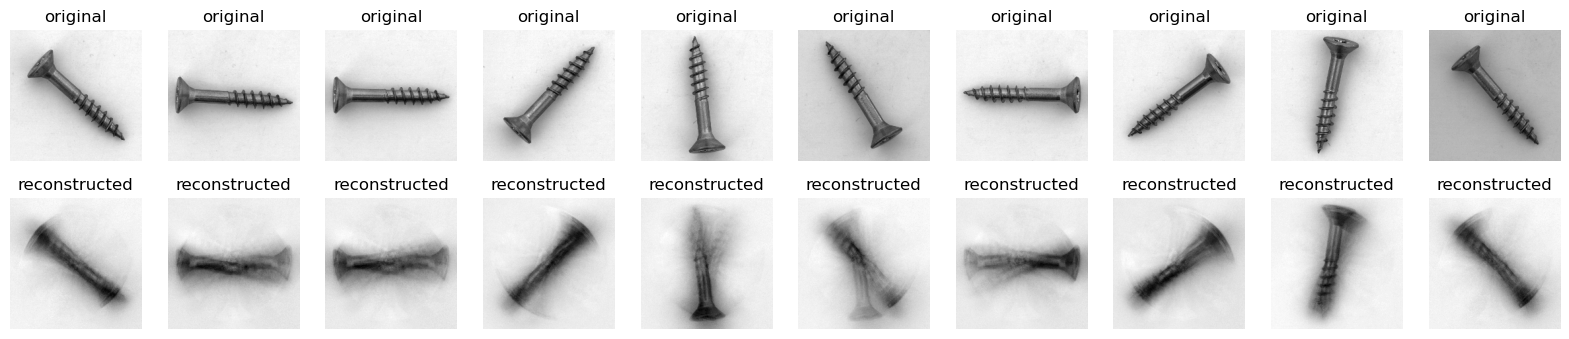

In [176]:
num_of_imgs = 10
plt.figure(figsize=(20,4))
for i in range(num_of_imgs):
    ax = plt.subplot(2, num_of_imgs, i + 1)
    plt.imshow(x_test_final[i], cmap='gray')
    plt.title("original")
    ax.axis('off')

    ax = plt.subplot(2, num_of_imgs, i + 1 + num_of_imgs)
    plt.imshow(decoded_imgs[i], cmap='gray')
    plt.title("reconstructed")
    ax.axis('off')
plt.show()

In [177]:
class Autoencoder(Model):
    def __init__(self, filter):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Conv2d()
            ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(latent_dim * 4, activation='relu'),
            layers.Dense(40000, activation='sigmoid'),
            layers.Reshape((200, 200))
            ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [178]:
test_img = x_train_np[3]
test_img = test_img / 255
test_img = test_img.reshape(1, 200, 200, 1)
img_in = tf.constant(test_img, dtype=tf.float32)

In [179]:
kernel_1 = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
kernel_1 = kernel_1.reshape(3, 3, 1, 1)
kernel_1 = tf.constant(kernel_1, dtype=tf.float32)


kernel_2 = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])
kernel_2 = kernel_2.reshape(3, 3, 1, 1)
kernel_2 = tf.constant(kernel_2, dtype=tf.float32)

kernel_3 = np.array([[-.5, -.5, 1],
                     [-.5, 1, -.5],
                     [1, -.5, -.5]])
kernel_3 = kernel_3.reshape(3, 3, 1, 1)
kernel_3 = tf.constant(kernel_3, dtype=tf.float32)

kern_list = [kernel_1, kernel_2, kernel_3]

In [180]:
def conv_loop(image, kernels, loops:int=10):
    out_put = []
    for k_in in kernels:
        img_p = image
        img_r = tf.image.rot90(img_p)
        for _ in range(loops):
            conv2d_H = tf.nn.conv2d(image, k_in, strides=(1,1), padding='SAME')
            conv2d_V = tf.nn.conv2d(img_r, k_in, strides=(1,1), padding='SAME')
            conv2d_V  = tf.image.rot90(conv2d_V, k=3)
            img_p = conv2d_H + conv2d_V
        img_fin = img_p.numpy()
        img_fin = img_fin.reshape(200, 200, 1)
        out_put.append(img_fin)
    return out_put

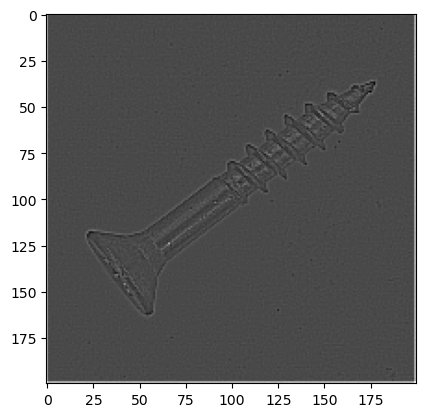

In [181]:
results  = conv_loop(img_in, kern_list, 100)
plt.imshow(results[1], cmap='gray')

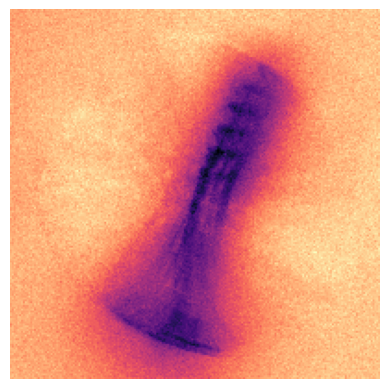

In [190]:
test = results[1].reshape(1, 200, 200)
encoded_test = autoencoder.encoder(test).numpy()
decoded_test = autoencoder.decoder(encoded_test).numpy()
plt.imshow(decoded_test.reshape(200, 200, 1), cmap="magma")
plt.axis('off')
plt.savefig('./images/eda_conv_test_2.png')
plt.show()

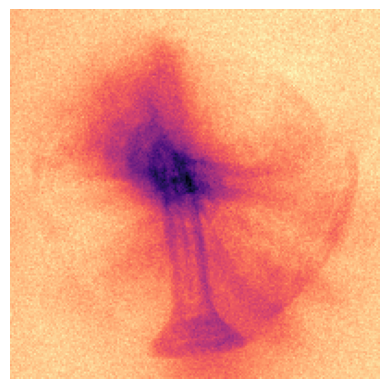

In [189]:
test = results[0].reshape(1, 200, 200)
encoded_test = autoencoder.encoder(test).numpy()
decoded_test = autoencoder.decoder(encoded_test).numpy()
plt.imshow(decoded_test.reshape(200, 200, 1), cmap="magma")
plt.axis('off')
plt.savefig('./images/eda_conv_test.png')
plt.show()

In [381]:
class Sharper(tf.keras.layers.Layer):
    def __init__(self, input_dim):
        super(Sharper, self).__init__()
        self.sharper = self.sharpen(x, kernel, passes)
    def sharpen(self)

In [16]:
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.models.Sequential([
            layers.Input(shape=(200, 200, 1)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1), # (200, 200, 1, 16)
            # layers.Reshape((200, 200, 16, 1)),
            # layers.MaxPool3D((4, 4, 4), padding='same', data_format='channels_last'), # output should be (50, 50, 4, 1)
            # layers.Flatten(),
            # layers.Dense(100, activation='relu')
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=1),
            ])
        self.decoder = Sequential([
            layers.Conv2DTranspose(8, 3, strides=2, activation='relu', padding='same'),
            # layers.Dense(10000, activation='sigmoid'),
            # layers.Reshape((50, 50, 4, 1)),
            # layers.Conv3DTranspose(1, 4, activation="sigmoid", padding='same', strides=(4, 4, 4)),
            layers.Conv2D(1, 3, strides=2, activation='sigmoid', padding='same')
            ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [17]:
x_2_train_np = np.array(list(map(lambda x : x[0], x_train.as_numpy_iterator())), 'float16')
x_2_train_final = x_2_train_np.astype('float16') / 255
x_2_train_final = x_2_train_final.reshape(320, 200, 200, 1)
x_2_train_final.shape

(320, 200, 200, 1)

In [18]:
x_2_test_np = np.array(list(map(lambda x : x[0], x_test.as_numpy_iterator())), 'float16')
x_2_test_final = x_2_test_np.astype('float16') / 255
x_2_test_final = x_2_test_final.reshape(160, 200, 200, 1)
x_2_test_final.shape

(160, 200, 200, 1)

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [36]:
convenc = AutoEncoder()
convenc.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [41]:
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/opt/cuda"
convenc.fit(x_2_train_final, x_2_train_final,
            epochs=100,
            shuffle=True,
            callbacks = [callback],
            validation_data=(x_2_test_final, x_2_test_final))

Epoch 1/100
10/10 [==============================] - 1s 141ms/step - loss: 1.5276e-04 - val_loss: 1.4605e-04
Epoch 2/100
10/10 [==============================] - 1s 121ms/step - loss: 1.7405e-04 - val_loss: 2.1535e-04
Epoch 3/100
10/10 [==============================] - 1s 122ms/step - loss: 1.7299e-04 - val_loss: 1.5862e-04
Epoch 4/100
10/10 [==============================] - 1s 122ms/step - loss: 1.6489e-04 - val_loss: 1.4862e-04


Encoder Output: (1, 200, 200, 8)
Decoder Output: (1, 200, 200, 1)


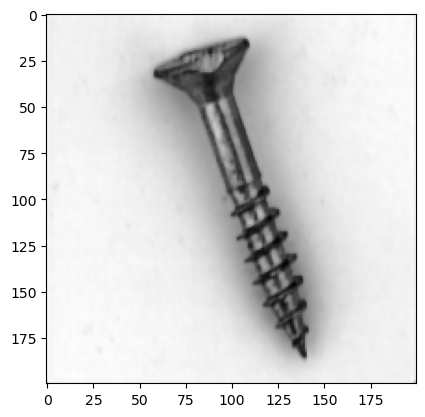

In [42]:
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/home/drew/conda/envs/tf_env/"
input = x_test_final[80].reshape(1, 200, 200, 1)

peek = convenc.encoder(input)
print(f"Encoder Output: {peek.shape}")

peek = convenc.decoder(peek)
print(f"Decoder Output: {peek.shape}")

plt.imshow(tf.reshape(peek, [200, 200, 1]), cmap='gray')

(200, 200, 1)


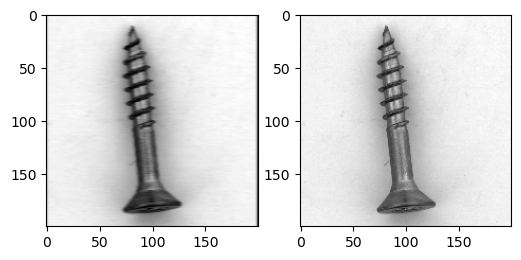

In [43]:
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/opt/cuda/"
img = x_2_test_final[4]
input = img.reshape(200, 200, 1)
print(input.shape)

out_put = convenc.encoder(input)
restruct = tf.reshape(convenc.decoder(out_put), [200, 200, 1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.imshow(restruct, cmap='gray')
ax2.imshow(img, cmap='gray')

In [45]:
input_samp = x_2_test_final
print(f"Input Shape: {input_samp.shape}")

Input Shape: (160, 200, 200, 1)


In [46]:
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/home/drew/conda/envs/tf_env/"
encoded_samp = convenc.encoder(input_samp)
print(f"Encoded Shape: {encoded_samp[:15:].shape}")

Encoded Shape: (15, 200, 200, 8)


In [47]:
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/opt/cuda/"
out_put = convenc.decoder(encoded_samp)
print(f"Decoded Shape: {out_put.shape}")
img_list = tf.reshape(out_put, [160, 200, 200, 1])

Decoded Shape: (160, 200, 200, 1)


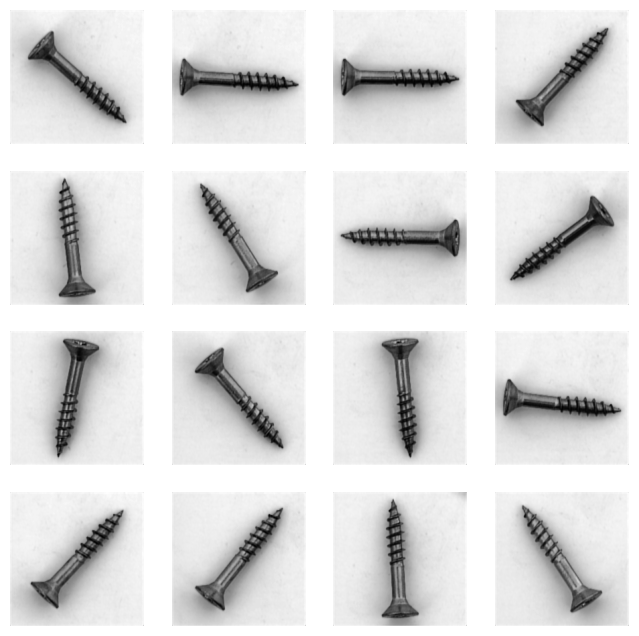

In [48]:
plt.figure(figsize=(8, 8))
for i, img in enumerate(img_list[:16:]):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()